# Supplementary Information: Holmes *et al.* 2017

# 7. Treatment effects

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

To do this, we extend the model with a treatment effect offset by introducing the coefficient $\delta$, to represent a global influence on slope, due to the passage step being included in the experiment. We again use the covariate $t_i$ as a 0/1 value that indicates whether the probe $i$ was measured as a *control* (0) or *treatment* (1) experiment. The value $\delta t_i x_i$ is therefore a global slope correction describing the relationship between *input* and *output* (i.e how much an *input* is modified to give the *output*) that is ascribable to the treatment.

We therefore construct the following model of the experiment:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma t_i + \delta t_i x_i + \epsilon_i$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $t_i$: 0/1 indicating whether the probe $i$ was measured in a control (0) or treatment (1) experiment
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$
* $\mu_{\alpha}$: the mean offset for all *probe ID*s
* $\sigma_{\alpha}$: the standard deviation of the offset for all *probe ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*; this is drawn from a Normal distribution $\sim N(\mu_{\beta}, \sigma_{\beta}^2)$
* $\mu_{\beta}$: the mean slope for all *probe ID*s
* $\sigma_{\beta}$: the standard deviation of the slope for all *probe ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\gamma$: a global estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment (i.e. an intercept correction)
* $\gamma$: a global estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment, as a function of the *input* measured intensity (i.e. a slope correction)
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique probe IDs (`J` < `N`)
* `probe`: `int[N]`, an index list of probe identities - one index representing six probe measurements (i.e. three control, three treatment) - there are `J` probes
* `t`: `vector[N]`, 0/1 control/treatment values for each probe
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, representative input log(intensity)
* `mu_a`: `real`, an unconstrained value to be fit that represents the mean offset for each probe ID
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a probe ID
* `mu_b`: `real`, an unconstrained value to be fit that represents the mean slope for each probe ID
* `g`: `real`, estimate of the influence of treatment on the output measured intensity (offset)
* `d`: `real`, estimate of the influence of treatment on the output measured intensity (slope)
* `sigma`: `real<lower=0>`, the error in the prediction
* `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the offset per probe ID
* `sigma_b`: `real<lower=0,upper=100>`, standard deviation of the slope per probe ID

We also define a `transformed parameter`:

* `y_hat[i] <- b[probe[i]] * x[i] + a[probe[i]] + g * t[i] + d * t[i] * x[i]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as:

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\beta_{j[i]} \sim N(\mu_{\beta}, \sigma_{\beta}^2)$$
$$y \sim N(\hat{y}, \sigma^2)$$


In [2]:
# load clean, normalised, indexed data
# data = pd.read_csv("output/normalised_array_data.tab", sep="\t")  # full dataset
data = pd.read_csv("output/reduced_normalised_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
probe_ids = data['probe'].unique()
nprobes = len(probe_ids)

In [3]:
# define unpooled stan model
treatment_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> probe[N];
  vector[N] t;
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  real g;
  real d;
  real mu_a;
  real mu_b;
  real<lower=0> sigma;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_b;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[probe[i]] + b[probe[i]] * x[i] + g * t[i] + d * t[i] * x[i];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal(mu_a, sigma_a);

  sigma_b ~ uniform(0, 100);
  b ~ normal(mu_b, sigma_b);

y ~ normal(y_hat, sigma);
}
"""

In [4]:
# relate python variables to stan variables
treatment_data_dict = {'N': len(data),
                       'J': nprobes,
                       'probe': data['probe_index'] + 1,
                       't': data['treatment'],
                       'x': data['log_input'],
                       'y': data['log_output']}

In [5]:
# run stan fit
treatment_fit = pystan.stan(model_code=treatment_model,
                            data=treatment_data_dict,
                            iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d6c292d4b0a43787a7be8b04aa525a8a NOW.


## Inspecting the fit

We're interested again in how the 'base' fit of the relationship between *input* and *output* is modified when we take a treatment effect offset into account, and also in the size of this effect on the estimate of slope.

In [6]:
# Get fits to alpha, beta, gamma by probe ID
alpha_estimates = pd.Series(treatment_fit['a'].mean(0), index=probe_ids)
alpha_se = pd.Series(treatment_fit['a'].std(0), index=probe_ids)
beta_estimates = pd.Series(treatment_fit['b'].mean(0), index=probe_ids)
beta_se = pd.Series(treatment_fit['b'].std(0), index=probe_ids)
gamma_mean = treatment_fit['g'].mean(0)
gamma_se = treatment_fit['g'].std(0)
delta_mean = treatment_fit['d'].mean(0)
delta_se = treatment_fit['d'].std(0)

In [7]:
# Inspect the estimates
alpha_estimates.head()

A_07_P038676   -0.280150
A_07_P033759    0.262653
A_07_P033727   -0.065610
A_07_P033715   -0.037601
A_07_P040893    0.550515
dtype: float64

In [8]:
# Inspect the estimates
beta_estimates.head()

A_07_P038676    0.976751
A_07_P033759    0.977199
A_07_P033727    0.977153
A_07_P033715    0.976795
A_07_P040893    0.977799
dtype: float64

In [9]:
# Inspect the estimates
print(gamma_mean, tools.print_intervals(treatment_fit, 'g', 50))

0.646912547787 g 50%CI: 0.628..0.665


In [10]:
# Inspect the estimates
print(delta_mean, tools.print_intervals(treatment_fit, 'd', 50))

-0.092618175559 d 50%CI: -0.095..-0.090


The estimate of the offset $\gamma$ due to the treatment effect has changed markedly with the introduction of $\delta$, and the 50% CI now includes zero. The mean estimates for $\alpha_{j[i]}$ and $\beta_{j[i]}$ appear to have been restored.

$\delta$ takes values that are, on the whole, negative, but very close to zero. The net global effect of introducing the treatment term is, therefore, essentially neutral. But we are not accounting for this effect in a groupwise manner, and that may be more informative.

### Intercept $\alpha_{j[i]}$

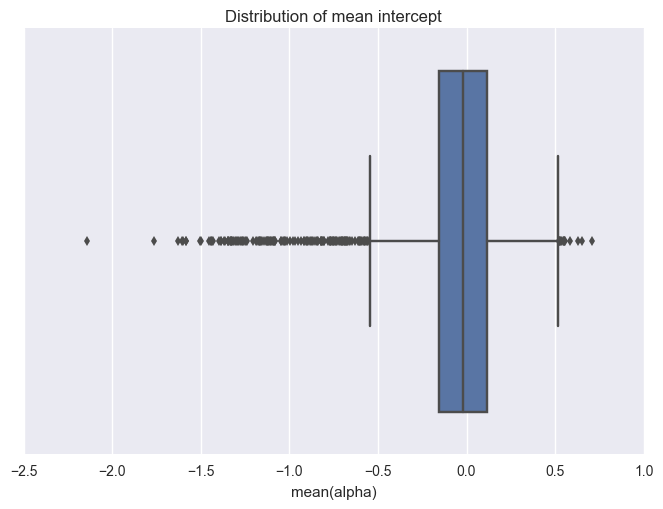

In [11]:
# Plot means distribution
g = sns.boxplot(alpha_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(alpha)");

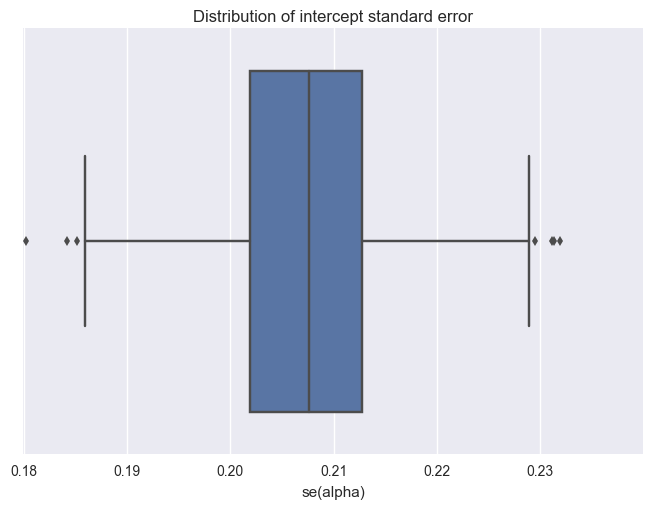

In [12]:
# Plot means distribution
g = sns.boxplot(alpha_se)
g.set_title("Distribution of intercept standard error")
g.set_xlabel("se(alpha)");

### Slopes $\beta_{j[i]}$

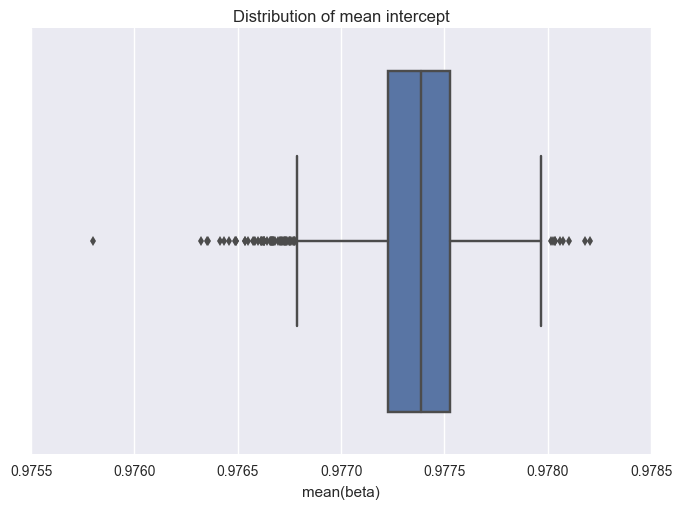

In [13]:
# Plot means distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(beta)");

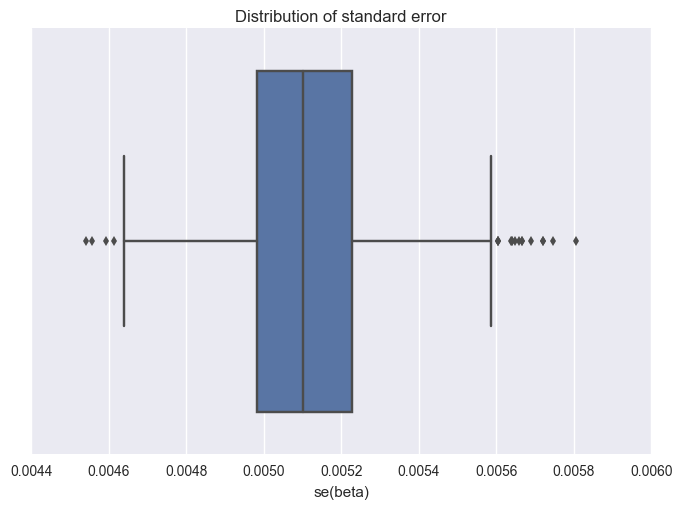

In [14]:
# Plot error distribution
g = sns.boxplot(beta_se)
g.set_title("Distribution of standard error")
g.set_xlabel("se(beta)");

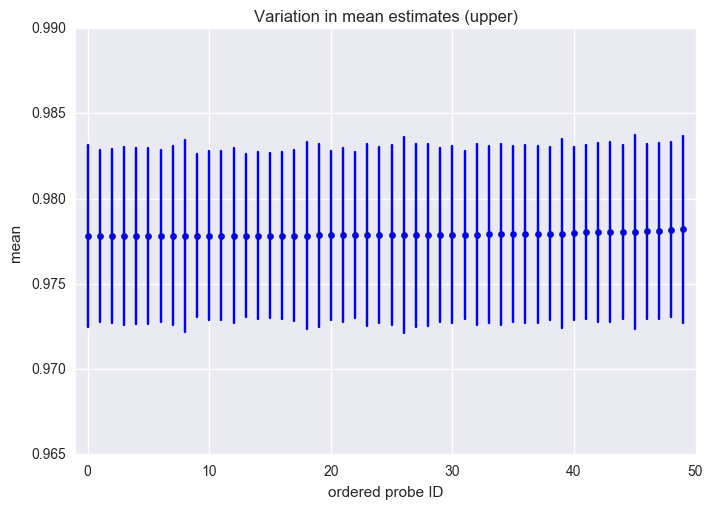

In [17]:
# errors for intercept outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.9778)

### Treatment offset $\gamma$

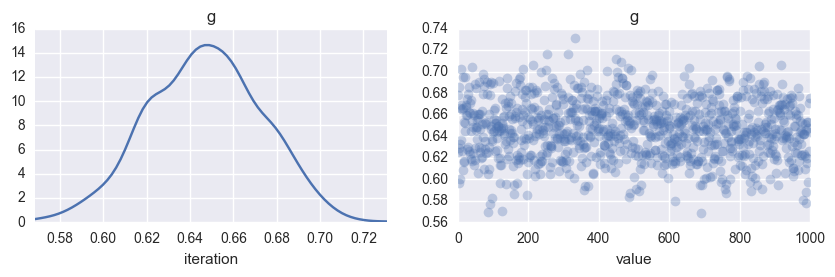

In [19]:
# Plot fitted parameters
tools.plot_fit_params(treatment_fit, ['g'])

### Treatment slope $\delta$

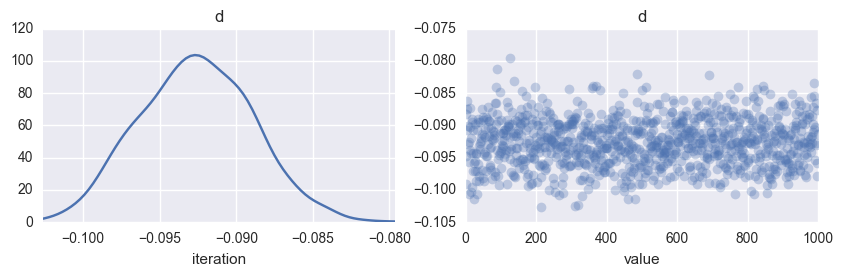

In [20]:
# Plot fitted parameters
tools.plot_fit_params(treatment_fit, ['d'])